# Dependencies

In [ ]:
import os
foundation_path = ""
os.chdir(foundation_path)
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt, seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm

import torch
import torch.nn as nn
import joblib

from sklearn.preprocessing import MinMaxScaler

from torch.utils.data import TensorDataset
from module import MSE_loss, MSE_diff_loss, Trend_loss
from module import Load_dataset

# Load Dataset

In [2]:
data_raw = Load_dataset(foundation_path=os.path.join(foundation_path,"Data"))

/home/bxai4/financial/FingFinge/module.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  kospi_raw = yf.download(kospi200_ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/home/bxai4/financial/FingFinge/module.py:33: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix_raw = yf.download('^VIX', start=start, end=end)
[*********************100%***********************]  1 of 1 completed


In [3]:
print("Shape:", data_raw.shape)
print("Columns:", data_raw.columns.tolist())
print("Date range:", data_raw['orig_date'].min(), "→", data_raw['orig_date'].max())
print(data_raw.info())
print(data_raw.head(3))
print(data_raw.tail(3))
# Basic stats
print(data_raw.describe().T[['mean','std','min','max']])
# Missing values per column
print("NaNs per column:\n", data_raw.isna().sum())

Shape: (5372, 6)
Columns: ['orig_date', 'VIX_Close', 'KOSPI200', 'USD_KRW', 'target', 'DGS10']
Date range: 2004-01-02 00:00:00 → 2025-09-30 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5372 entries, 0 to 5371
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   orig_date  5372 non-null   datetime64[ns]
 1   VIX_Close  5202 non-null   float64       
 2   KOSPI200   5321 non-null   float64       
 3   USD_KRW    5190 non-null   float64       
 4   target     5372 non-null   float64       
 5   DGS10      5177 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 251.9 KB
None
   orig_date  VIX_Close    KOSPI200  USD_KRW  target  DGS10
0 2004-01-02  18.219999  106.650002   1195.1   20.89   4.38
1 2004-01-05  17.490000  107.070000   1192.1   21.46   4.41
2 2004-01-06  16.730000  106.900002   1186.0   21.32   4.29
      orig_date  VIX_Close    KOSPI200  USD_KRW  target  DGS10


In [4]:
df = data_raw.copy()

df['orig_date'] = pd.to_datetime(df['orig_date'])
df = df.sort_values('orig_date').set_index('orig_date')

feat_cols   = ['VIX_Close', 'KOSPI200', 'USD_KRW', 'DGS10']
target_col  = ['target']

df[feat_cols] = df[feat_cols].ffill()

df = df.dropna(subset=target_col + feat_cols)  

cols = target_col + feat_cols
print(df.agg(['skew', 'kurtosis'])[cols].T)

               skew   kurtosis
target     2.719674  11.732148
VIX_Close  2.614006  10.080998
KOSPI200   0.069943  -0.090971
USD_KRW    0.466367   0.049186
DGS10     -0.035226  -1.056963


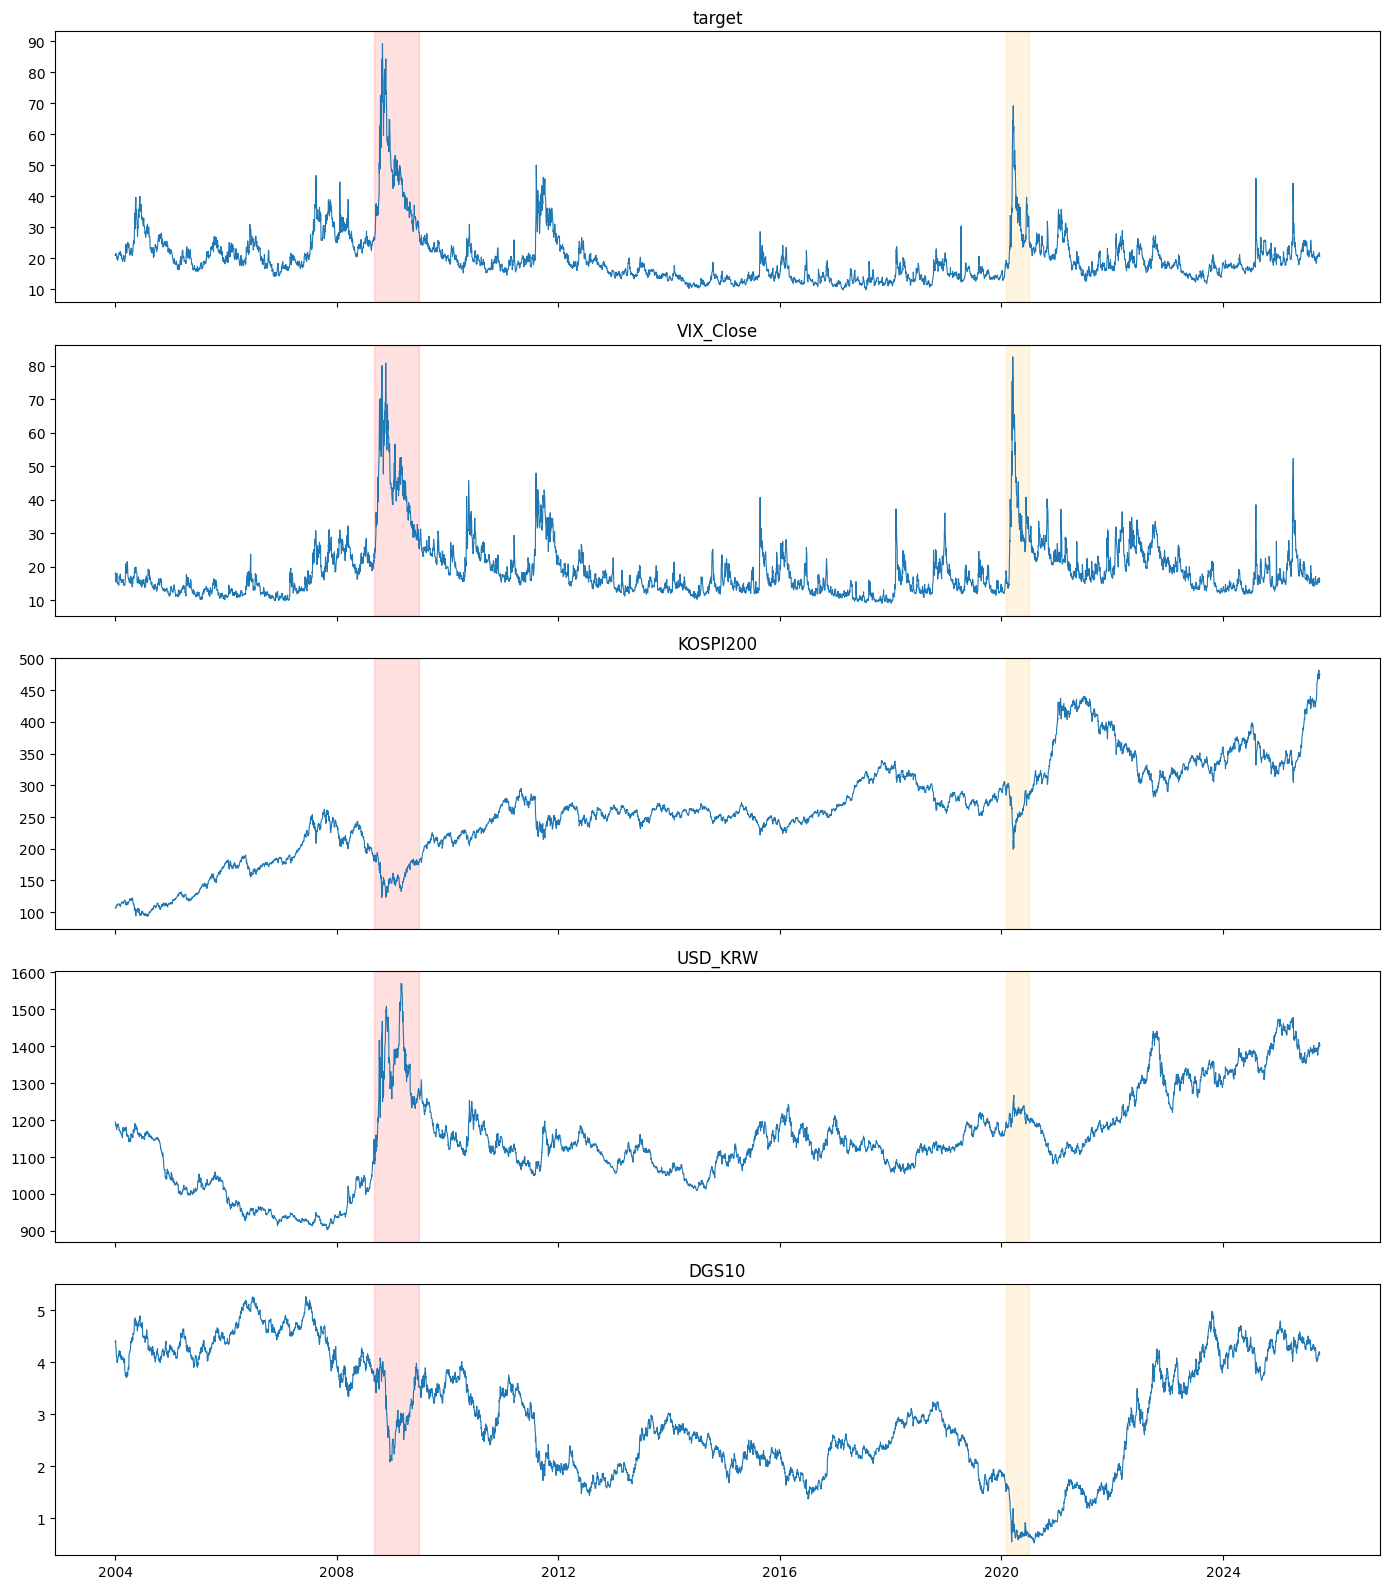

In [5]:
df.index = pd.to_datetime(df.index)

fig, axes = plt.subplots(5, 1, figsize=(14, 16), sharex=True)
cols = ["target", "VIX_Close", "KOSPI200", "USD_KRW", "DGS10"]

c1s, c1e = pd.Timestamp("2008-09-01"), pd.Timestamp("2009-06-30")   # The Great Recession
c2s, c2e = pd.Timestamp("2020-02-01"), pd.Timestamp("2020-06-30")   # Covid19

for ax, col in zip(axes, cols):
    ax.plot(df.index, df[col], lw=0.8)
    ax.set_title(f"{col}")
    
    ax.axvspan(c1s, c1e, color="red", alpha=0.12)
    ax.axvspan(c2s, c2e, color="orange", alpha=0.12)
    
plt.tight_layout()
plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name=''):
    result = adfuller(series.dropna())
    print(f"=== ADF Test: {name} ===")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value:.4f}")
    if result[1] < 0.05:
        print("→ stationary\n")
    else:
        print("→ non-stationary\n")

cols = ['target', 'VIX_Close', 'KOSPI200', 'USD_KRW', 'DGS10']

for col in cols:
    adf_test(data_raw[col], name=col)

=== ADF Test: target ===
ADF Statistic: -4.9465
p-value: 0.0000
Critical Values:
    1%: -3.4316
    5%: -2.8621
    10%: -2.5671
→ stationary

=== ADF Test: VIX_Close ===
ADF Statistic: -5.0504
p-value: 0.0000
Critical Values:
    1%: -3.4316
    5%: -2.8621
    10%: -2.5671
→ stationary

=== ADF Test: KOSPI200 ===
ADF Statistic: -0.8872
p-value: 0.7922
Critical Values:
    1%: -3.4316
    5%: -2.8621
    10%: -2.5671
→ non-stationary

=== ADF Test: USD_KRW ===
ADF Statistic: -2.0476
p-value: 0.2661
Critical Values:
    1%: -3.4316
    5%: -2.8621
    10%: -2.5671
→ non-stationary

=== ADF Test: DGS10 ===
ADF Statistic: -1.7561
p-value: 0.4025
Critical Values:
    1%: -3.4316
    5%: -2.8621
    10%: -2.5671
→ non-stationary



In [7]:
df_pre = df.copy()

# 1) KOSPI log return
df_pre['KOSPI200_LogRet'] = np.log(df_pre['KOSPI200']) - np.log(df_pre['KOSPI200'].shift(1))

# 2) USD/KRW log return
df_pre['USD_KRW_LogRet'] = np.log(df_pre['USD_KRW']) - np.log(df_pre['USD_KRW'].shift(1))

# 3) interest rate difference
df_pre['DGS10_diff'] = df_pre['DGS10'].diff()

df_pre = df_pre.dropna()

df_pre = df_pre[['target', 'VIX_Close', 'KOSPI200_LogRet', 'USD_KRW_LogRet', 'DGS10_diff']]
df_pre.index.name = 'orig_date'

In [8]:
print(df_pre.info())
print(df_pre.head(3))
print(df_pre.tail(3))
feat_cols_pre   = ['VIX_Close', 'KOSPI200_LogRet', 'USD_KRW_LogRet', 'DGS10_diff']
target_col  = ['target']

cols_pre = target_col + feat_cols_pre
print(df_pre.agg(['skew', 'kurtosis'])[cols_pre].T)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5371 entries, 2004-01-05 to 2025-09-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   target           5371 non-null   float64
 1   VIX_Close        5371 non-null   float64
 2   KOSPI200_LogRet  5371 non-null   float64
 3   USD_KRW_LogRet   5371 non-null   float64
 4   DGS10_diff       5371 non-null   float64
dtypes: float64(5)
memory usage: 251.8 KB
None
            target  VIX_Close  KOSPI200_LogRet  USD_KRW_LogRet  DGS10_diff
orig_date                                                                 
2004-01-05   21.46      17.49         0.003930       -0.002513        0.03
2004-01-06   21.32      16.73        -0.001589       -0.005130       -0.12
2004-01-07   21.03      15.50         0.005969        0.000843       -0.02
            target  VIX_Close  KOSPI200_LogRet  USD_KRW_LogRet  DGS10_diff
orig_date                                                

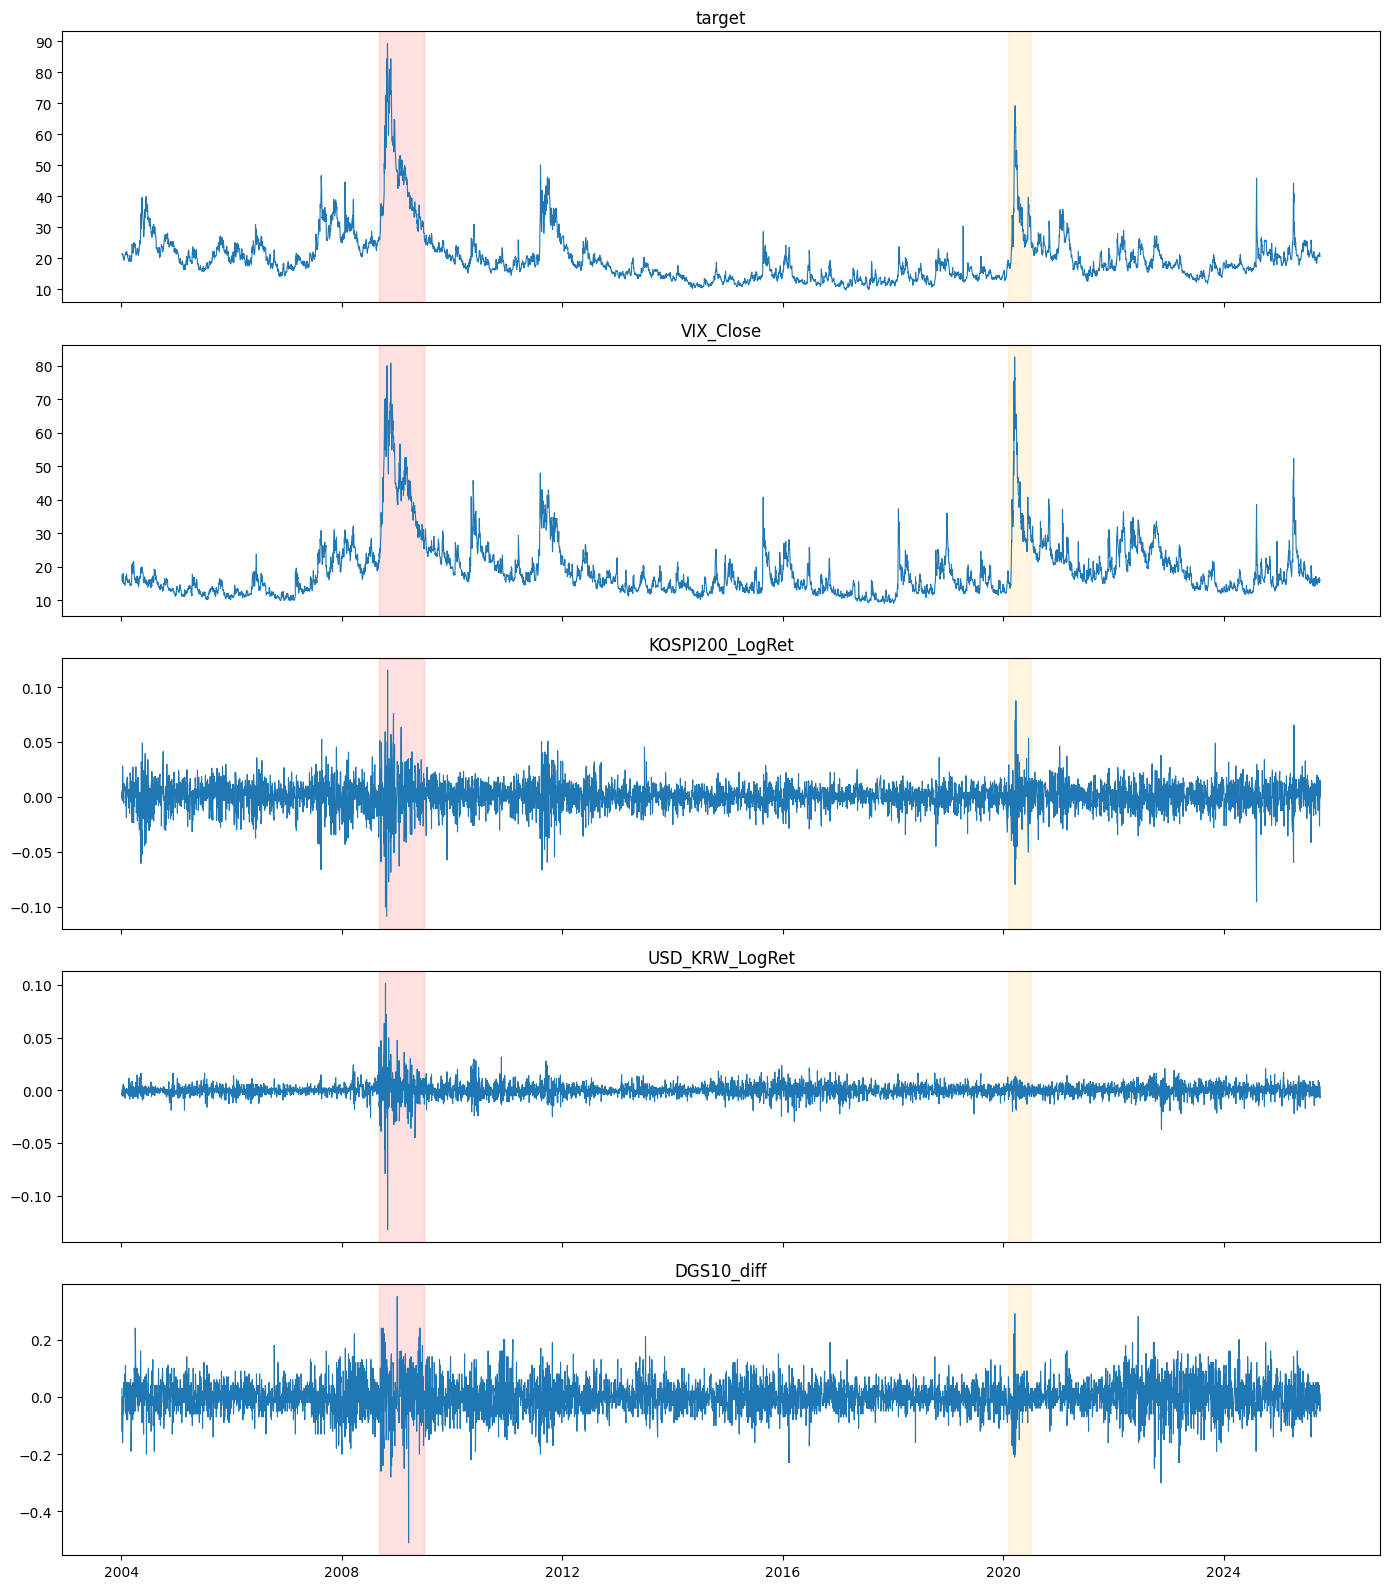

In [9]:
df_pre.index = pd.to_datetime(df_pre.index)

fig, axes = plt.subplots(5, 1, figsize=(14, 16), sharex=True)
cols = ["target", "VIX_Close", "KOSPI200_LogRet", "USD_KRW_LogRet", "DGS10_diff"]

c1s, c1e = pd.Timestamp("2008-09-01"), pd.Timestamp("2009-06-30")   # The Great Recession
c2s, c2e = pd.Timestamp("2020-02-01"), pd.Timestamp("2020-06-30")   # Covid19

for ax, col in zip(axes, cols):
    ax.plot(df_pre.index, df_pre[col], lw=0.8)
    ax.set_title(f"{col}")
    
    ax.axvspan(c1s, c1e, color="red", alpha=0.12)
    ax.axvspan(c2s, c2e, color="orange", alpha=0.12)
    
plt.tight_layout()
plt.show()

In [10]:
cols = ["target", "VIX_Close", "KOSPI200_LogRet", "USD_KRW_LogRet", "DGS10_diff"]

for col in cols:
    adf_test(df_pre[col], name=col)

=== ADF Test: target ===
ADF Statistic: -4.9458
p-value: 0.0000
Critical Values:
    1%: -3.4316
    5%: -2.8621
    10%: -2.5671
→ stationary

=== ADF Test: VIX_Close ===
ADF Statistic: -5.8044
p-value: 0.0000
Critical Values:
    1%: -3.4316
    5%: -2.8621
    10%: -2.5671
→ stationary

=== ADF Test: KOSPI200_LogRet ===
ADF Statistic: -73.1621
p-value: 0.0000
Critical Values:
    1%: -3.4316
    5%: -2.8621
    10%: -2.5671
→ stationary

=== ADF Test: USD_KRW_LogRet ===
ADF Statistic: -11.8656
p-value: 0.0000
Critical Values:
    1%: -3.4316
    5%: -2.8621
    10%: -2.5671
→ stationary

=== ADF Test: DGS10_diff ===
ADF Statistic: -55.3521
p-value: 0.0000
Critical Values:
    1%: -3.4316
    5%: -2.8621
    10%: -2.5671
→ stationary



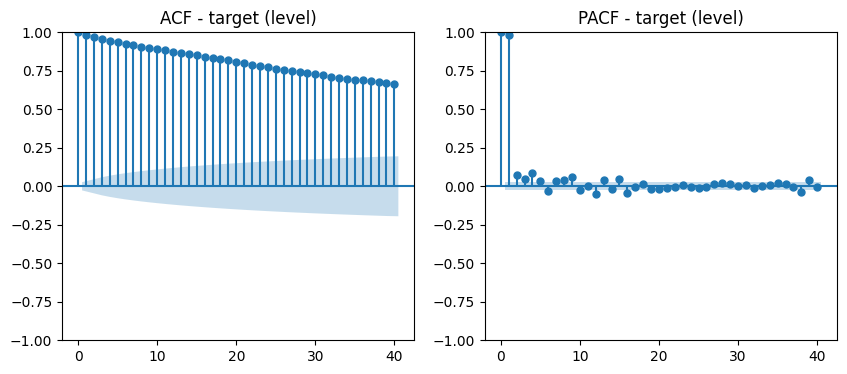

ADF p (수준) target: 2.8378353758709394e-05
ADF p (수준) VIX_Close: 4.551868006544299e-07
ADF p (수준) USD_KRW_LogRet: 6.685934338282518e-22
ADF p (수준) DGS10_diff: 0.0


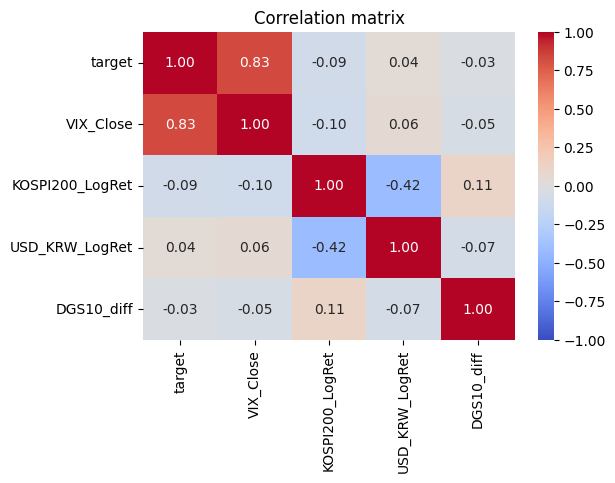

In [11]:
# VKOSPI ACF/PACF
fig, axes = plt.subplots(1,2, figsize=(10,4))
plot_acf(df_pre['target'].dropna(), lags=40, ax=axes[0])
plot_pacf(df_pre['target'].dropna(), lags=40, ax=axes[1])
axes[0].set_title("ACF - target (level)")
axes[1].set_title("PACF - target (level)")
plt.show()

# ADF
def adf_p(s): return adfuller(s.dropna())[1]

print("ADF p (수준) target:", adf_p(df_pre['target']))
print("ADF p (수준) VIX_Close:", adf_p(df_pre['VIX_Close']))
print("ADF p (수준) USD_KRW_LogRet:", adf_p(df_pre['USD_KRW_LogRet']))  # 이미 수익률
print("ADF p (수준) DGS10_diff:", adf_p(df_pre['DGS10_diff']))

# Correlation Heatmap
corr = df_pre[['target','VIX_Close','KOSPI200_LogRet','USD_KRW_LogRet','DGS10_diff']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix")
plt.show()

In [12]:
use_cols = ['target', 'VIX_Close', 'KOSPI200_LogRet', 'USD_KRW_LogRet', 'DGS10_diff']

df_model = df_pre[use_cols].dropna()
print(df_model.head())
print(df_model.shape)

# train / test 
train_end  = "2022-12-30"
test_start = "2023-01-02"

train = df_model.loc[:train_end].copy()
test  = df_model.loc[test_start:].copy()

print("train:", train.index[0], "→", train.index[-1], len(train))
print("test :", test.index[0],  "→", test.index[-1],  len(test))

            target  VIX_Close  KOSPI200_LogRet  USD_KRW_LogRet  DGS10_diff
orig_date                                                                 
2004-01-05   21.46      17.49         0.003930       -0.002513        0.03
2004-01-06   21.32      16.73        -0.001589       -0.005130       -0.12
2004-01-07   21.03      15.50         0.005969        0.000843       -0.02
2004-01-08   21.29      15.61        -0.003167       -0.003798        0.00
2004-01-09   21.38      16.75         0.028145       -0.000677       -0.16
(5371, 5)
train: 2004-01-05 00:00:00 → 2022-12-29 00:00:00 4699
test : 2023-01-02 00:00:00 → 2025-09-30 00:00:00 672


In [15]:
import warnings
warnings.filterwarnings("ignore", message="No supported index is available")
from statsmodels.tools.sm_exceptions import ValueWarning
from module import rmse, mae, mape

warnings.filterwarnings("ignore", category=ValueWarning)

# -------------------------------------------------------------
# 1) Split the target series into training and test sets
# -------------------------------------------------------------
y = df_model['target']
y_train = y.loc[:train_end]
y_test_ar = y.loc[test_start:]   # use explicit variable name for clarity

# -------------------------------------------------------------
# 2) Select the optimal AR order (p) based on BIC
# -------------------------------------------------------------
ar_bic_list = []
for p in range(1, 21):
    model = sm.tsa.ARIMA(y_train, order=(p, 0, 0)).fit()
    ar_bic_list.append((p, model.bic))

ar_bic_df = pd.DataFrame(ar_bic_list, columns=['p', 'BIC']).sort_values('BIC')
print(ar_bic_df.head())
best_p = int(ar_bic_df.iloc[0]['p'])
print("Selected AR order p* =", best_p)

# -------------------------------------------------------------
# 3) Rolling 1-step-ahead forecasting
#    - Fit AR model on 'history_ar'
#    - Predict the next value
#    - Append the actual test value to history
# -------------------------------------------------------------
history = y_train.copy()
preds_ar = []  # <-- AR prediction array

for t in y_test_ar.index:
    model = sm.tsa.ARIMA(history, order=(best_p, 0, 0)).fit()
    pred = model.forecast(1).iloc[0]
    preds_ar.append(pred)
    history.loc[t] = y.loc[t]  # append actual value

preds_ar = np.array(preds_ar)

# -------------------------------------------------------------
# 4) Evaluation (AR baseline performance)
# -------------------------------------------------------------
print("=== AR Baseline Performance ===")
print("RMSE:", rmse(y_test_ar.values, preds_ar))
print("MAE :", mae(y_test_ar.values, preds_ar))
print("MAPE:", mape(y_test_ar.values, preds_ar))

     p           BIC
3    4  17509.942756
4    5  17513.940111
8    9  17515.563038
15  16  17515.583980
5    6  17516.376739
Selected AR order p* = 4
=== AR Baseline Performance ===
RMSE: 1.623472589606811
MAE : 0.712406236846742
MAPE: 3.4160465130046744


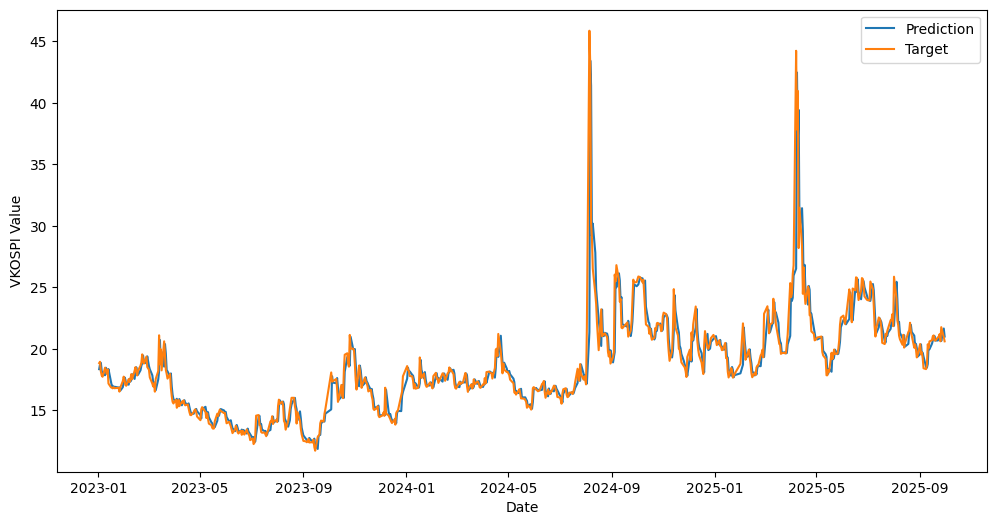

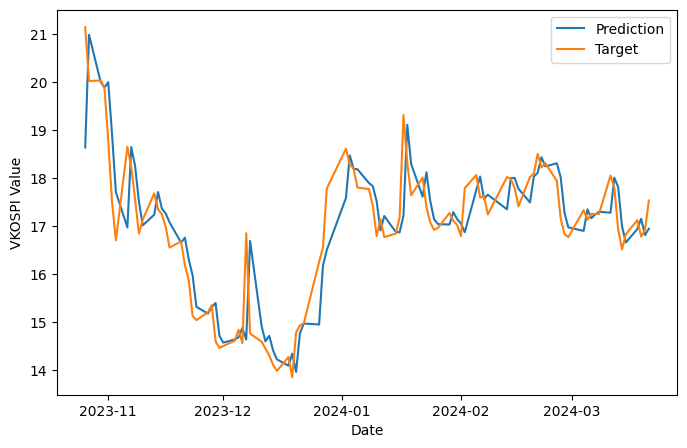

In [17]:
# ------------------------------------------------------------
# Build prediction DataFrame for plotting
# ------------------------------------------------------------
pred_df = pd.DataFrame({
    "orig_date": y_test_ar.index,
    "target": y_test_ar.values,
    "prediction": preds_ar, 
}).set_index("orig_date")

# ------------------------------------------------------------
# Plot Prediction vs Actual
# ------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(pred_df["prediction"], label="Prediction (AR)")
plt.plot(pred_df["target"], label="Target")
plt.xlabel("Date")
plt.ylabel("VKOSPI Value")
plt.legend()
plt.show()

# ------------------------------------------------------------
# Plot a zoomed-in window
# ------------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(pred_df["prediction"].iloc[200:300], label="Prediction (AR)")
plt.plot(pred_df["target"].iloc[200:300], label="Target")
plt.xlabel("Date")
plt.ylabel("VKOSPI Value")
plt.legend()
plt.show()

In [18]:
from statsmodels.tsa.api import VAR

df_var = df_model.copy()

# ------------------------------------
# 1) Select optimal VAR lag (p) using BIC
# ------------------------------------
var_train = df_var.loc[:train_end]

var_model = VAR(var_train)
lag_results = var_model.select_order(maxlags=10)  # you can increase maxlags if needed
print(lag_results.summary())

best_lag = lag_results.selected_orders['bic']
print("Selected VAR lag (p*) =", best_lag)

# ------------------------------------
# 2) 1-step-ahead rolling forecast (VAR)
# ------------------------------------
history = df_var.loc[:train_end].copy()
y_test_var = df_var.loc[test_start:].copy()

preds_var = []  # <-- VAR prediction array (for all variables)

for t in y_test_var.index:
    model = VAR(history)
    result = model.fit(best_lag)

    # Use the last `best_lag` observations to forecast 1 step ahead
    fcst = result.forecast(history.values[-best_lag:], steps=1)
    pred_vec = fcst[0]  # numpy array: predictions for all variables at time t
    preds_var.append(pred_vec)

    # Append the actual observation at time t to history
    history.loc[t] = y_test_var.loc[t]

preds_var = np.array(preds_var)

# ------------------------------------
# 3) Extract target forecasts and evaluate
# ------------------------------------
target_idx = list(df_var.columns).index('target')
var_target_pred   = preds_var[:, target_idx]
var_target_actual = y_test_var['target'].values

print("=== VAR performance (target) ===")
print("RMSE:", rmse(var_target_actual, var_target_pred))
print("MAE :", mae(var_target_actual, var_target_pred))
print("MAPE:", mape(var_target_actual, var_target_pred))

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -17.06      -17.05   3.910e-08      -17.05
1       -23.16      -23.11   8.782e-11      -23.14
2       -23.40      -23.32   6.902e-11      -23.37
3       -23.46     -23.35*   6.465e-11      -23.42
4       -23.49      -23.34   6.294e-11      -23.44
5       -23.49      -23.32   6.261e-11      -23.43
6       -23.51      -23.30   6.138e-11      -23.44
7       -23.53      -23.28   6.025e-11     -23.45*
8       -23.54      -23.26   5.979e-11      -23.44
9       -23.55      -23.23   5.927e-11      -23.44
10     -23.56*      -23.21  5.875e-11*      -23.43
--------------------------------------------------
Selected VAR lag (p*) = 3
=== VAR performance (target) ===
RMSE: 1.3956473541261591
MAE : 0.653346195646825
MAPE: 3.1419968851842515


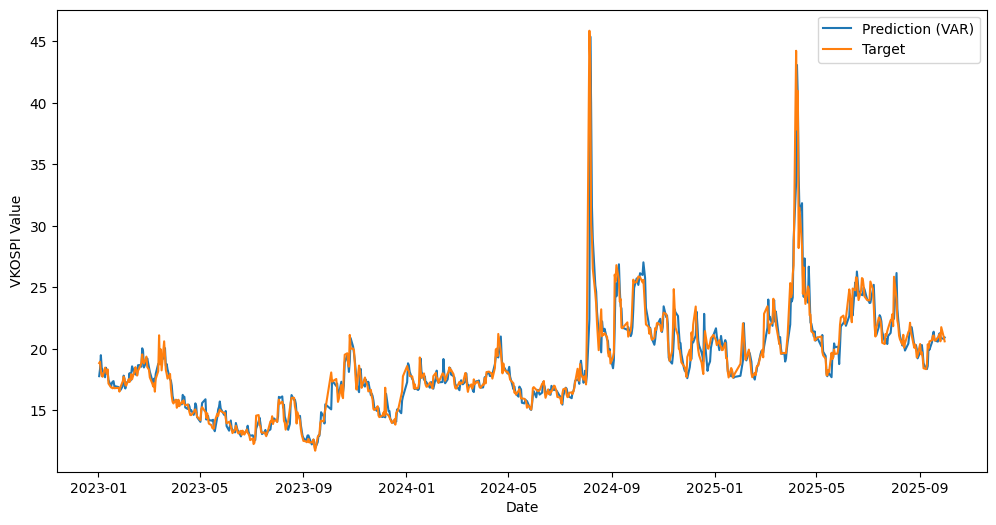

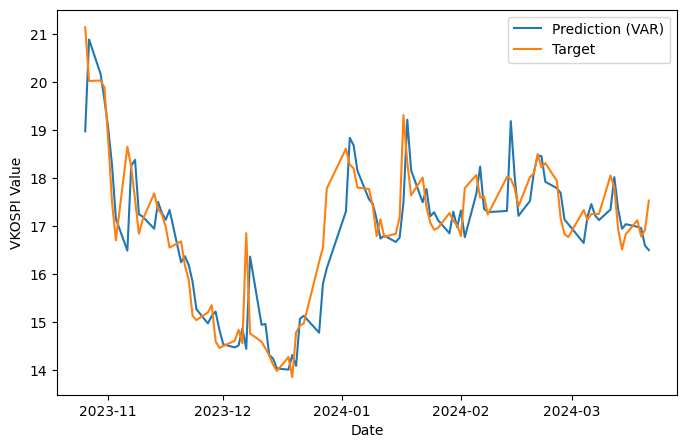

In [19]:
# ------------------------------------------------------------
# Build prediction DataFrame for plotting (VAR)
# ------------------------------------------------------------
pred_df_var = pd.DataFrame({
    "orig_date": y_test_var.index,
    "target": y_test_var["target"].values,
    "prediction": var_target_pred,   # only target forecast
}).set_index("orig_date")

# ------------------------------------------------------------
# Plot Prediction vs Actual (full period)
# ------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(pred_df_var["prediction"], label="Prediction (VAR)")
plt.plot(pred_df_var["target"], label="Target")
plt.xlabel("Date")
plt.ylabel("VKOSPI Value")
plt.legend()
plt.show()

# ------------------------------------------------------------
# Plot a zoomed-in window
# ------------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(pred_df_var["prediction"].iloc[200:300], label="Prediction (VAR)")
plt.plot(pred_df_var["target"].iloc[200:300], label="Target")
plt.xlabel("Date")
plt.ylabel("VKOSPI Value")
plt.legend()
plt.show()

In [20]:
import statsmodels.api as sm
from module import rmse, mae, mape

# ------------------------------------
# 0) Define target and regressors
# ------------------------------------
y_col  = 'target'
x_cols = ['VIX_Close', 'KOSPI200_LogRet', 'USD_KRW_LogRet', 'DGS10_diff']  # <- df_model 기준에 맞춰 수정

# ------------------------------------
# 1) Function to build ADL dataset with lags
# ------------------------------------
def make_adl_df(data, y_col, x_cols, p_y=1, p_x=1):
    """
    Build ADL design matrix:
      - y(t) as dependent variable
      - y(t-1)...y(t-p_y), x_j(t), x_j(t-1)...x_j(t-p_x) as regressors
    """
    df_adl = data.copy()
    
    # Lags of y
    for i in range(1, p_y + 1):
        df_adl[f"{y_col}_lag{i}"] = df_adl[y_col].shift(i)
    
    # Lags of each x
    for x in x_cols:
        for i in range(0, p_x + 1):
            df_adl[f"{x}_lag{i}"] = df_adl[x].shift(i)
    
    # Drop initial rows with NaNs due to lagging
    df_adl = df_adl.dropna()
    return df_adl

# ------------------------------------
# 2) Grid search over (p_y, p_x) using BIC on TRAIN period
# ------------------------------------
best_bic  = np.inf
best_spec = None

for p_y in [1, 2, 3]:      # candidate lags for y
    for p_x in [0, 1, 2]:  # candidate lags for x
        df_adl = make_adl_df(df_model, y_col, x_cols, p_y=p_y, p_x=p_x)
        
        # use only training period
        train_adl = df_adl.loc[:train_end]
        
        y_train_adl = train_adl[y_col]
        X_train_adl = sm.add_constant(train_adl.drop(columns=[y_col]))
        
        model = sm.OLS(y_train_adl, X_train_adl).fit()
        
        if model.bic < best_bic:
            best_bic  = model.bic
            best_spec = (p_y, p_x)

print("Selected ADL (p_y, p_x) =", best_spec, ", BIC =", best_bic)

Selected ADL (p_y, p_x) = (2, 2) , BIC = 14434.463805675176


In [21]:
# ------------------------------------
# 3) Rebuild full ADL dataset with best (p_y, p_x)
# ------------------------------------
p_y, p_x = best_spec
df_adl_full = make_adl_df(df_model, y_col, x_cols, p_y=p_y, p_x=p_x)

y_all = df_adl_full[y_col]
X_all = sm.add_constant(df_adl_full.drop(columns=[y_col]))

print(df_adl_full.head())
print(df_adl_full.shape)

# ------------------------------------
# 4) Define ADL test dates (based on df_adl_full index)
#    Note: early dates are dropped due to lags
# ------------------------------------
test_dates = df_adl_full.loc[test_start:].index

# ------------------------------------
# 5) Rolling 1-step-ahead forecast (ADL)
#    - For each date in test_dates:
#        * estimate OLS using all data strictly before 'date'
#        * predict y at 'date'
# ------------------------------------
preds_adl = []

for date in test_dates:
    # use only observations strictly before 'date' as training
    train_mask = df_adl_full.index < date
    
    y_train_roll = y_all[train_mask]
    X_train_roll = X_all[train_mask]
    
    model = sm.OLS(y_train_roll, X_train_roll).fit()
    
    # one-step-ahead prediction at 'date'
    X_current = X_all.loc[date:date]
    pred = model.predict(X_current).iloc[0]
    preds_adl.append(pred)

preds_adl = np.array(preds_adl)

# actual test target values
y_test_adl = y_all.loc[test_dates].values

# ------------------------------------
# 6) Evaluate ADL performance
# ------------------------------------
print("=== ADL Performance ===")
print("RMSE:", rmse(y_test_adl, preds_adl))
print("MAE :", mae(y_test_adl, preds_adl))
print("MAPE:", mape(y_test_adl, preds_adl))

            target  VIX_Close  KOSPI200_LogRet  USD_KRW_LogRet  DGS10_diff  \
orig_date                                                                    
2004-01-07   21.03  15.500000         0.005969        0.000843       -0.02   
2004-01-08   21.29  15.610000        -0.003167       -0.003798        0.00   
2004-01-09   21.38  16.750000         0.028145       -0.000677       -0.16   
2004-01-12   20.83  16.820000         0.007589       -0.005686        0.00   
2004-01-13   20.46  18.040001        -0.003517        0.005093       -0.06   

            target_lag1  target_lag2  VIX_Close_lag0  VIX_Close_lag1  \
orig_date                                                              
2004-01-07        21.32        21.46       15.500000           16.73   
2004-01-08        21.03        21.32       15.610000           15.50   
2004-01-09        21.29        21.03       16.750000           15.61   
2004-01-12        21.38        21.29       16.820000           16.75   
2004-01-13        20.

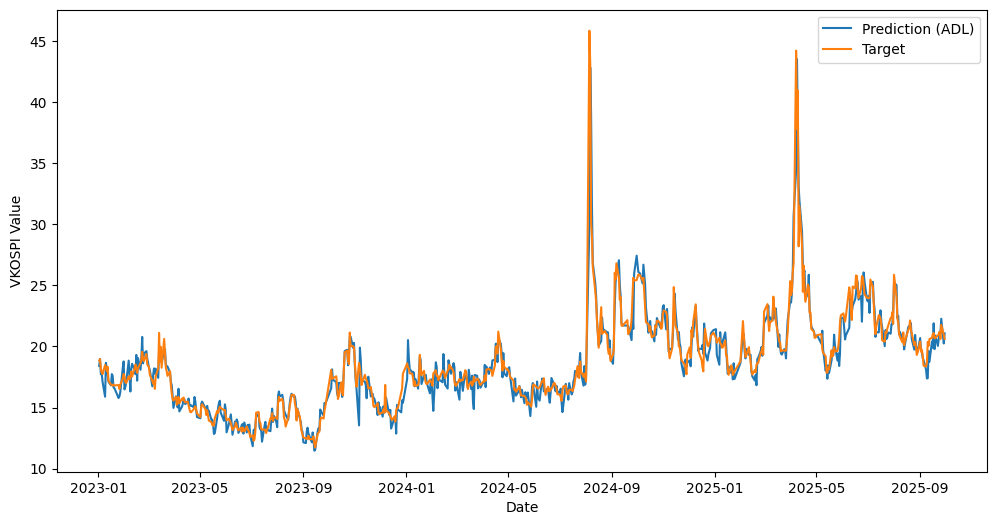

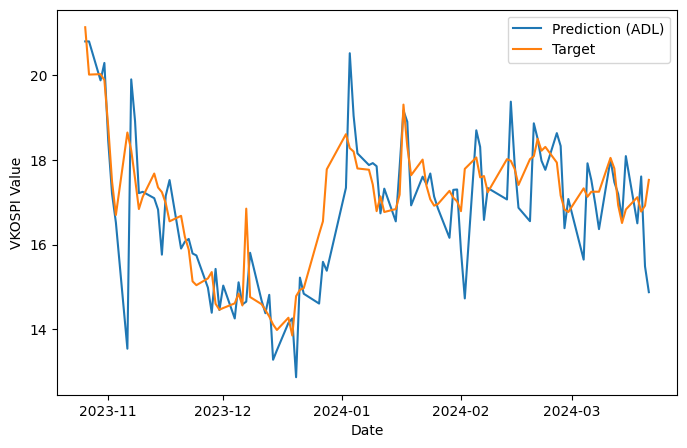

In [22]:
# ------------------------------------------------------------
# Build prediction DataFrame for plotting (ADL)
# ------------------------------------------------------------
pred_df_adl = pd.DataFrame(
    {
        "target":      y_test_adl,
        "prediction":  preds_adl,
    },
    index=test_dates
)
pred_df_adl.index.name = "orig_date"

# ------------------------------------------------------------
# Plot Prediction vs Actual (full test period)
# ------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(pred_df_adl["prediction"], label="Prediction (ADL)")
plt.plot(pred_df_adl["target"],     label="Target")
plt.xlabel("Date")
plt.ylabel("VKOSPI Value")
plt.legend()
plt.show()

# zoom-in example
plt.figure(figsize=(8, 5))
plt.plot(pred_df_adl["prediction"].iloc[200:300], label="Prediction (ADL)")
plt.plot(pred_df_adl["target"].iloc[200:300],     label="Target")
plt.xlabel("Date")
plt.ylabel("VKOSPI Value")
plt.legend()
plt.show()

In [23]:
from statsmodels.tsa.stattools import grangercausalitytests

# ------------------------------------------------------------
# 0) Settings: target and candidate explanatory variables
# ------------------------------------------------------------
y_col  = 'target'
x_cols = ['VIX_Close', 'KOSPI200_LogRet', 'USD_KRW_LogRet', 'DGS10_diff']

max_lag = 5  # you can change this (e.g., 3, 10, etc.)

# ------------------------------------------------------------
# 1) Run Granger causality tests for each X -> target
# ------------------------------------------------------------
gc_results = {}   # to store full results per variable
summary_rows = [] # to store (variable, lag, p-value) for a compact summary

for x in x_cols:
    print("\n" + "=" * 60)
    print(f"Granger causality test: {x}  ->  {y_col}")
    print("=" * 60)

    # Granger test expects a 2-column DataFrame: [y, x]
    # Here we drop NaN to align the two series
    data_gc = df_model[[y_col, x]].dropna()

    # Run test for lags = 1 ... max_lag
    # H0: x does NOT Granger-cause y
    res = grangercausalitytests(data_gc, maxlag=max_lag, verbose=True)
    gc_results[x] = res

    # Extract p-values (SSR F-test) for each lag
    for lag in range(1, max_lag + 1):
        pval = res[lag][0]['ssr_ftest'][1]  # p-value of SSR F-test
        summary_rows.append((x, lag, pval))

# ------------------------------------------------------------
# 2) Build a compact summary table of p-values
# ------------------------------------------------------------
gc_summary = pd.DataFrame(summary_rows,
                          columns=['variable', 'lag', 'p_value'])

# Pivot to see lags (rows) × variables (columns)
gc_pivot = gc_summary.pivot(index='lag', columns='variable', values='p_value')

print("\n\n===== Granger causality p-value summary (SSR F-test) =====")
print(gc_pivot)
print("\n(Usually you check whether p_value < 0.05 to reject H0: 'no Granger causality')")


Granger causality test: VIX_Close  ->  target

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=221.2079, p=0.0000  , df_denom=5367, df_num=1
ssr based chi2 test:   chi2=221.3315, p=0.0000  , df=1
likelihood ratio test: chi2=216.8919, p=0.0000  , df=1
parameter F test:         F=221.2079, p=0.0000  , df_denom=5367, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=609.8351, p=0.0000  , df_denom=5364, df_num=2
ssr based chi2 test:   chi2=1220.8071, p=0.0000  , df=2
likelihood ratio test: chi2=1100.0136, p=0.0000  , df=2
parameter F test:         F=609.8351, p=0.0000  , df_denom=5364, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=472.8089, p=0.0000  , df_denom=5361, df_num=3
ssr based chi2 test:   chi2=1420.2789, p=0.0000  , df=3
likelihood ratio test: chi2=1260.0953, p=0.0000  , df=3
parameter F test:         F=472.8089, p=0.0000  , df_denom=5361, df_num=3

Granger Causality
number of lags (no

/home/bxai4/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/bxai4/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/bxai4/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/bxai4/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


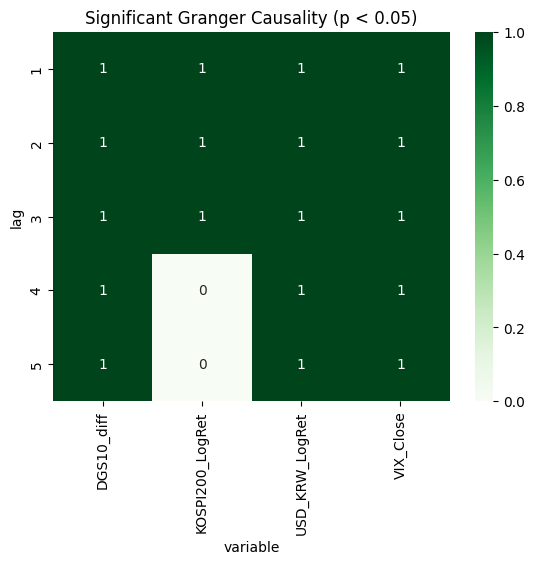

In [26]:
sig_matrix = (gc_pivot < 0.05).astype(int)

sns.heatmap(sig_matrix, annot=True, cmap="Greens")
plt.title("Significant Granger Causality (p < 0.05)")
plt.show()